In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data.sampler import WeightedRandomSampler

from triagerx.dataset.processor import DatasetProcessor
from triagerx.model.roberta_cnn import RobertaCNNClassifier
from triagerx.trainer.model_trainer import ModelTrainer
from triagerx.trainer.train_config import TrainConfig

# Load Data

In [2]:
dataset_path = "/home/mdafifal.mamun/notebooks/triagerX/notebook/data/openj9/merged_data_dated.csv"

In [3]:
sample_threshold = 10

df = DatasetProcessor.process_dataset(dataset_path, sample_threshold=sample_threshold)

2024-01-15 13:08:30.442 | DEBUG    | triagerx.dataset.processor:load_dataframe:8 - Loading dataframe: /home/mdafifal.mamun/notebooks/triagerX/notebook/data/openj9/merged_data_dated.csv
2024-01-15 13:08:31.347 | DEBUG    | triagerx.dataset.processor:prepare_dataframe:24 - Filtering developers based on minimum contribution: 10...
2024-01-15 13:08:31.353 | DEBUG    | triagerx.dataset.processor:prepare_dataframe:32 - Generating 'text' field...
2024-01-15 13:08:31.394 | DEBUG    | triagerx.dataset.processor:prepare_dataframe:42 - Dropping rows with 'text' length < 15...
2024-01-15 13:08:31.402 | DEBUG    | triagerx.dataset.processor:clean_data:13 - Cleaning dataset...


<Axes: xlabel='assignees'>

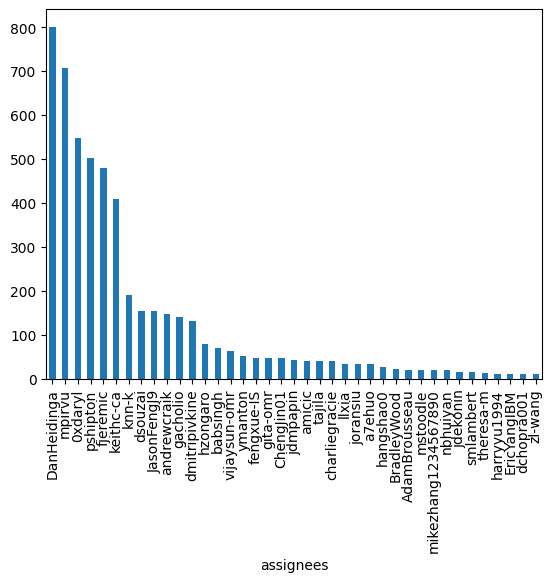

In [4]:
df["assignees"].value_counts().plot(kind="bar")

In [5]:
np.random.seed(42)
train_df, test_df = train_test_split(df, test_size=0.15, stratify=df["owner_id"])
train_df, valid_df = train_test_split(train_df, test_size=0.15, stratify=train_df["owner_id"])

In [6]:
assert len(train_df.owner_id.unique()) == len(train_df.owner_id.unique()) == len(valid_df.owner_id.unique())

# Training

In [7]:
model = RobertaCNNClassifier(
    model_name="roberta-base",
    output_size=len(train_df.owner_id.unique()),
    embed_size=768
)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
counts = np.bincount(train_df["owner_id"])
labels_weights = 1. / counts
weights = labels_weights[train_df["owner_id"]]
sampler = WeightedRandomSampler(weights, len(weights))

In [9]:
learning_rate = 1e-6
epochs = 50
batch_size = 15

# Create sampler
counts = np.bincount(train_df["owner_id"])
labels_weights = 1. / counts
weights = labels_weights[train_df["owner_id"]]
sampler = WeightedRandomSampler(weights, len(weights))

sampler_name = sampler.__class__.__name__ if sampler else "None"

output_file = f"roberta_cnn_{sample_threshold}_{sampler_name}"
output_path = f"/home/mdafifal.mamun/notebooks/triagerX/output/{output_file}.pt"

wandb_config = {
        "project": "triagerx",
        "name": f"run_{output_file}",
        "config": {
        "learning_rate": learning_rate,
        "architecture": "Roberta-CNN",
        "dataset": "openj9",
        "epochs": epochs,
    }
}

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

train_config = TrainConfig(
    optimizer=optimizer,
    criterion=criterion,
    train_dataset=train_df,
    validation_dataset=valid_df,
    learning_rate=learning_rate,
    batch_size=batch_size,
    epochs=epochs,
    output_file=output_path,
    sampler=sampler,
    wandb=wandb_config
)

trainer = ModelTrainer(train_config)
trainer.train(model=model)

2024-01-15 13:08:34.032 | DEBUG    | triagerx.dataset.triage_dataset:__init__:17 - Generating torch dataset...
2024-01-15 13:08:34.034 | DEBUG    | triagerx.dataset.triage_dataset:__init__:20 - Tokenizing texts...
2024-01-15 13:08:40.868 | DEBUG    | triagerx.dataset.triage_dataset:__init__:17 - Generating torch dataset...
2024-01-15 13:08:40.870 | DEBUG    | triagerx.dataset.triage_dataset:__init__:20 - Tokenizing texts...
2024-01-15 13:08:41.916 | DEBUG    | triagerx.trainer.model_trainer:train:31 - Initializing wandb...
wandb: Currently logged in as: afifaniks. Use `wandb login --relogin` to force relogin


2024-01-15 13:08:48.505 | DEBUG    | triagerx.trainer.model_trainer:train:46 - Selected compute device: cuda
  0%|                                                                                                                                                                                | 0/254 [00:00<?, ?it/s]/home/mdafifal.mamun/miniconda3/envs/trx/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1702400366987/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 254/254 [01:35<00:00,  2.67it/s]
2024-01-15 13:10:29.953 | INFO     | triagerx.trainer.model_trainer:_log_step:124 - Epochs: 1 | Train Loss:  0.242                     | Train Ac

# Evaluation

In [ ]:
import torch
from triagerx.evaluation.evaluator import Evaluator

In [ ]:
model = RobertaCNNClassifier(
    model_name="roberta-base",
    output_size=len(train_df.owner_id.unique()),
    embed_size=768
)
model.load_state_dict(torch.load(output_path))

evaluator = Evaluator()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Top 3 Predictions
evaluator.calculate_top_k_accuray(model, k=3, X_test=test_df, y_test=test_df["owner_id"].to_numpy())

2024-01-15 12:59:25.113 | DEBUG    | triagerx.evaluation.evaluator:calculate_top_k_accuray:20 - Calculating predications...
2024-01-15 12:59:38.008 | DEBUG    | triagerx.evaluation.evaluator:calculate_top_k_accuray:49 - Calculating top 3 score...
2024-01-15 12:59:38.011 | INFO     | triagerx.evaluation.evaluator:calculate_top_k_accuray:52 - Top K score: 0.730379746835443


0.730379746835443

In [ ]:
# Top 5 Predictions
evaluator.calculate_top_k_accuray(model, k=5, X_test=test_df, y_test=test_df["owner_id"].to_numpy())

2024-01-15 12:59:39.116 | DEBUG    | triagerx.evaluation.evaluator:calculate_top_k_accuray:20 - Calculating predications...
2024-01-15 12:59:51.825 | DEBUG    | triagerx.evaluation.evaluator:calculate_top_k_accuray:49 - Calculating top 5 score...
2024-01-15 12:59:51.828 | INFO     | triagerx.evaluation.evaluator:calculate_top_k_accuray:52 - Top K score: 0.7962025316455696


0.7962025316455696